In [1]:
import theano
import theano.tensor as tt
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt

# Define model data
x_array, y_CurvesMatrix = np.arange(
    4700, 6200), np.loadtxt('stellar_spectra.txt')
weightsTrue = np.array([0.75, 1.1, 0.5, 0.2])       # Declare each curve weight
# Generate synthetic observation
spectrumTrue = weightsTrue.dot(y_CurvesMatrix)

# Add some noise
error_Pixel = 0.02
obsNoise = np.random.normal(0, error_Pixel, size=x_array.size)

# Observed spectrum curve
obsSpectrum = spectrumTrue + obsNoise
# Data for the priors
# Give distribution centers some offset
weights_priors = np.array([0.735, 1.15, 0.525, 0.192])
weights_std = weightsTrue * 0.10
n_weights = weightsTrue.size

# Std for the likelihood
curveUncertainty_array = error_Pixel * np.ones(x_array.size)

/home/junpenglao/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


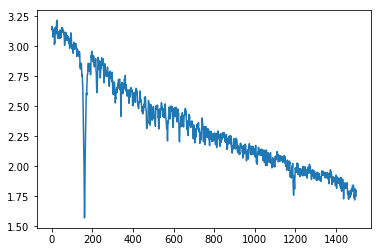

In [4]:
plt.plot(obsSpectrum);

In [5]:
# Declare theano variables
curvesMatrix_tt = theano.shared(y_CurvesMatrix)

# Pymc3 model
with pm.Model() as model:
    # Weights prior
    w_i = pm.Normal('w_i', mu=weights_priors, sd=weights_std, shape=n_weights)
    # Synthetic emission of the model
    spectrum = w_i.dot(curvesMatrix_tt)

    # Likelihood
    Y = pm.Normal('Y', 
                  mu=spectrum, 
                  sd=curveUncertainty_array,
                  observed=obsSpectrum)

    # Launch model
    model.check_test_point()
    trace_nuts = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [w_i]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:47<00:00, 84.07draws/s] 
The acceptance probability does not match the target. It is 0.8852667114505484, but should be close to 0.8. Try to increase the number of tuning steps.


In [14]:
weightsFit_nutts = trace_nuts['w_i'][:100]

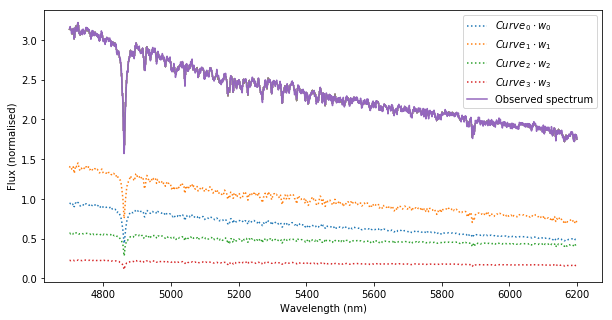

In [19]:
# Plot model output data
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for i in np.arange(y_CurvesMatrix.shape[0]):
    ax.plot(x_array, y_CurvesMatrix[i, :] * weightsTrue[i],
            label=r'$Curve_{{\,{}}}\cdot w_{{{}}}$'.format(i, i), linestyle=':')
    
ax.plot(x_array, weightsFit_nutts.dot(y_CurvesMatrix).T, linestyle='-', alpha=.01)
ax.plot(x_array, obsSpectrum, label='Observed spectrum')
ax.update({'xlabel': 'Wavelength (nm)', 'ylabel': 'Flux (normalised)'})
ax.legend()
plt.show()